In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tqdm.auto import tqdm

In [ ]:
def read_every_nth_frame( video_capture, n):
	frame_count = 0
	frames = []
	while video_capture.isOpened():
		ret, frame = video_capture.read()

		if not ret:
			break

		if frame_count % n == 0:
			frames.append( cv2.cvtColor( frame, cv2.COLOR_BGR2RGB))

		frame_count += 1

	return np.array( frames)

In [ ]:
cap = cv2.VideoCapture( "image/MyRecord_20241116133821.mp4")

if cap.isOpened() == False:
	print( "Error Opening Video stream")

frames = read_every_nth_frame( cap, 1)

In [ ]:
frames.shape

In [2]:
frame = cv2.imread( "sample.png")

frame = cv2.cvtColor( frame, cv2.COLOR_BGR2RGB)

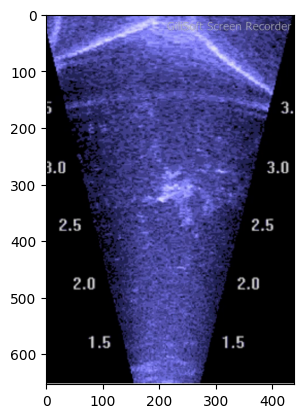

In [3]:
plt.imshow( frame)

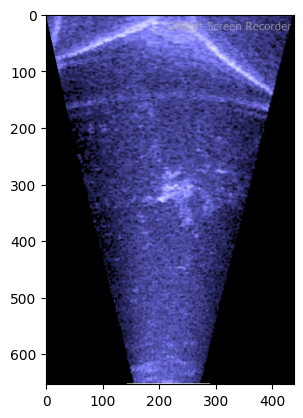

In [4]:
height, width, _ = frame.shape

mask = np.zeros_like( frame)
# triangle = np.array( [ [ 0, height], [ width // 2, 0],  [ width, height]], np.int32)

polygon = np.array( [
	[ width * 0.33, height],	# Bottom-left
	[ width * 0.66, height],	# Botton-Right
	[ width, 0],				# Top-Right
	[ 0, 0],					# Top-Left
], np.int32)

mask = cv2.fillPoly( mask, [ polygon], [ 255, 255, 255])

masked_image = cv2.bitwise_and( frame, mask)

plt.imshow( masked_image)

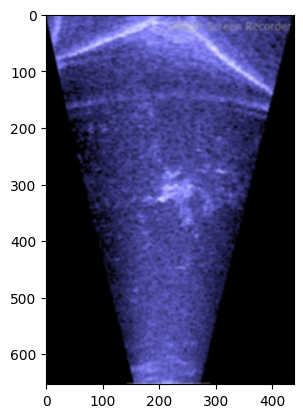

In [5]:
blurred_frame = cv2.GaussianBlur( masked_image, ( 5, 5), sigmaX=2, sigmaY=2)

plt.imshow( blurred_frame)

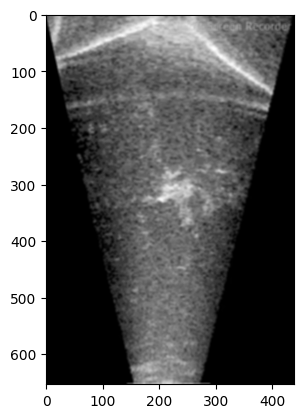

In [6]:
gray_frame = cv2.cvtColor( blurred_frame, cv2.COLOR_BGR2GRAY)

plt.imshow( gray_frame, cmap="gray")

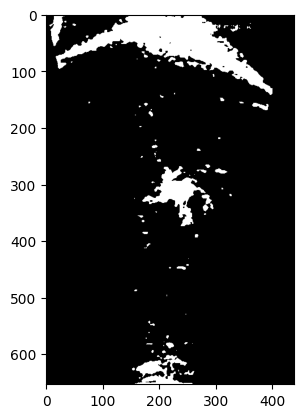

In [7]:
c = 0.5

_, binary_frame = cv2.threshold( gray_frame, int( c * 255), 255, cv2.THRESH_BINARY)

plt.imshow( binary_frame, cmap="gray")

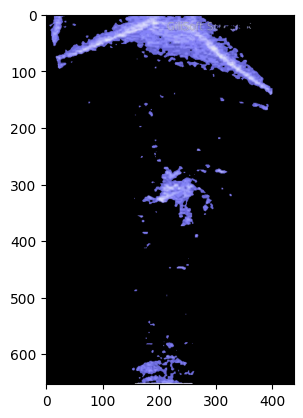

In [8]:
filtered_image = cv2.bitwise_and( frame, np.stack( [ binary_frame] * 3, axis=-1))

plt.imshow( filtered_image)

In [9]:
def img_to_feature( img):
	height, width, channels = img.shape

	features = np.zeros( ( height * width, channels + 2))

	for h in range( height):
		for w in range( width):
			features[ h * width + w, 0:3] = img[ h, w]
			features[ h * width + w, 3:5] = [ h, w]

	return features

In [10]:
def feature_to_img( feature):
	samples, n_feature = feature.shape

	height, width = feature[ -1, -2:]

	img = np.zeros( ( int( height) + 1, int( width) + 1, n_feature - 2), dtype=np.uint8)

	for s in range( samples):
		r, g, b, h, w = feature[ s]
		img[ int( h), int( w)] = [ r, g, b]

	return img

In [11]:
features = img_to_feature( filtered_image)

In [12]:
kmeans = KMeans( n_clusters=30, n_init="auto").fit( features[ :, :3])

In [13]:
invalid_clusters = np.where( ( kmeans.cluster_centers_ < 1).all( axis=1))

invalid_clusters

(array([0], dtype=int64),)

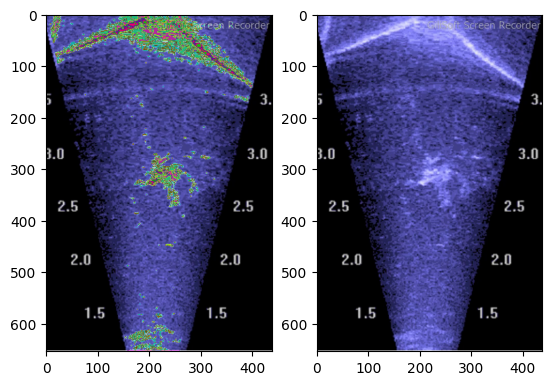

In [14]:
features2 = img_to_feature( frame)
cluster_xy = []
for i in range( len( kmeans.cluster_centers_)):
	if i in invalid_clusters:
		continue
	# features2[ kmeans.labels_ == i, :3] = kmeans.cluster_centers_[ i].astype( np.uint8)
	features2[ kmeans.labels_ == i, :3] = np.random.randint( 0, 256, 3)
	cluster_xy.append( features2[ kmeans.labels_ == i, 3:].mean( axis=0).astype( int))
	# cluster_xy.append( np.quantile( features2[ kmeans.labels_ == i, 3:], 0.9, axis=0, method="nearest").astype( int))
	# cluster_xy.append( [
	# 	np.bincount( features2[ kmeans.labels_ == i, -2].astype( int)).argmin(),
	# 	np.bincount( features2[ kmeans.labels_ == i, -1].astype( int)).argmin()
	# ])

rimg = feature_to_img( features2)

plt.subplot( 1, 2, 1)
plt.imshow( rimg)
plt.subplot( 1, 2, 2)
plt.imshow( frame)

In [ ]:
# cluster_centers = kmeans.cluster_centers_[ :, -2:].astype( int)
output_image = frame.copy()

for c in cluster_xy:
	cv2.circle( output_image, ( c[ 1], c[ 0]), 10, ( 255, 0, 0), 2)

plt.imshow( output_image)